# Load, Visualize MCMC Results

In [1]:
%matplotlib inline
import pyfits
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 15
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
import photPack2
from astropy.time import Time
import emcee
import george
from george import kernels

## Read in raw data, organize
rawch1 = np.genfromtxt('spitzer/wasp6_channel1.txt')
rawch2 = np.genfromtxt('spitzer/wasp6_channel2.txt')

# Load initial fitting parameters from spitzer/spitzer-fit-results.ipynb
spitzerinitparams = np.load('spitzer/max_lnp_params_201501301021.npy')

ch1 = {}
ch2 = {}
for rawdata, output in zip([rawch1, rawch2], [ch1, ch2]):
    for i, key, offset in zip(range(3), ['t', 'f', 'e'], [2450000.0, 0.0, 0.0]):
        output[key] = rawdata[:,i] + offset

for ch in [ch1, ch2]:
    ch['e'] = np.zeros_like(ch['f']) + np.std(ch['f'][int(0.66*len(ch['f'])):])

fluxes = np.load('photoutputs/fluxes.npy')
errors = np.load('photoutputs/errors.npy')
times = np.load('photoutputs/times.npy')
airmass = np.load('photoutputs/airmass.npy')
wavelengthbincenters = np.load('photoutputs/wavelengthbincenters.npy')
exposuredurs = np.load('photoutputs/exposuredurs.npy')
wavelengthbounds = np.load('photoutputs/wavelengthbounds.npy')

#samples = np.load('firstchain20141210.npy')
lightcurve = fluxes[:, 1, :, 0]/fluxes[:, 0, :, 0]
lightcurve_errors = lightcurve*np.sqrt((errors[:, 1, :, 0]/fluxes[:, 1, :, 0])**2 + (errors[:, 0, :, 0]/fluxes[:, 0, :, 0])**2)
Nbins = np.shape(lightcurve)[1]

def savecopies(figure, name, extensions=['.png', '.pdf']):
    dirs = ['./plotsforpaper/', '/astro/users/bmmorris/Dropbox/wasp6figs/', '/astro/users/bmmorris/Dropbox/sharelatex/MOSFIRE_WASP-6b/plots/']
    for dir in dirs:
        for ext in extensions:
            figure.savefig(dir+name+ext,bbox_inches='tight')

In [2]:
import sys
sys.path.append('/astro/users/bmmorris/Downloads/Fast_MA')
from ext_func.rsky import rsky
from ext_func.occultquad import occultquad

def get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t):
    '''
    e - eccentricity
    aRs - "a over R-star"
    i - inclination angle in radians
    u1, u2 - quadratic limb-darkening coeffs
    p0 - planet to star radius ratio
    w - argument of periapse
    period - period
    t0 - midtransit (JD)
    eps - minimum eccentricity for Kepler's equation
    t - time array
    '''
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    r_s = 1.0
    npoints = len(t)
    #calculates separation of centers between the planet and the star
    z0 = rsky(e, aRs, i, r_s, w, period, t0, eps, t)   
    #returns limb darkened model lightcurve
    mu_c = occultquad(z0, u1, u2, p0, npoints)   
    return F0*mu_c

def T14b2aRsi(P, T14, b):
    '''
    Convert from duration and impact param to a/Rs and inclination
    '''
    i = np.arccos( ( (P/np.pi)*np.sqrt(1 - b**2)/(T14*b) )**-1 )
    aRs = b/np.cos(i)
    return aRs, i

def aRsi2T14b(P, aRs, i):
    b = aRs*np.cos(i)
    T14 = (P/np.pi)*np.sqrt(1-b**2)/aRs
    return T14, b

def reparameterized_lc(T14, b, t0, q1, q2, p0, F0, e, w, period, eps, t):
    '''
    Reparameterization of the transit light curve in `get_lc()` with
    duration (first-to-fourth contact) instead of a/R* and impact
    parameter instead of inclination
    '''
    aRs, i = T14b2aRsi(period, T14, b)
    return get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t)


from scipy import optimize
aOverRs = 1./0.0932 # Jord`an et al 2013
RpOverRs = 0.1404   # Jord`an et al 2013
eccentricity = 0.0 # Husnoo 2012
inclination = 88.47*np.pi/180
q1 = 0.00001
q2 = 0.2
periapse = np.pi/2 # To match e=0, from Husnoo 2012
period = 3.36100239 # Nikolov 2015          #3.361006
mineccentricity = 1.0e-7
t0_roughfit = 2456918.8793039066

Nbins = np.shape(lightcurve)[1]
print Nbins
Nlightcurves = Nbins + 2
# aRs, i, t0, RpRs, LD, F0, am
paramlimits = [[8.0, 14.0],  #aRs
               [85*np.pi/180, 95.0*np.pi/180],
               [np.min(times), np.max(times)],
               [np.min(times), np.max(times)]] + \
               2*3*[[0, 1.0]] +\
               Nlightcurves*[[0.0, 0.3]] + \
               Nlightcurves*[[0.1, 10]] + \
               Nbins*[[0.0, 10.0]] + Nlightcurves*[[-13, -6]]
#               Nbins*[[1.0, 1e3]]
lastp = 0

mosfire_meantimediff = np.median(np.diff(times))
ch1_meantimediff = np.median(np.diff(ch1['t']))
ch2_meantimediff = np.median(np.diff(ch2['t']))
#mosfire_exptime = np.median(exposuredurs)/(60*60*24) # convert to units of days from seconds
def fine_lc(T, b, t0, q1, q2, p0, F0, e, w, period, eps, t, meantimediff):
    new_t = np.linspace(t.min() - 2*meantimediff, t.max() + 2*meantimediff, 5*len(t))
    #return new_t, get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, new_t)
    return new_t, reparameterized_lc(T, b, t0, q1, q2, p0, F0, e, w, period, eps, new_t)

def binned_lc(T, b, t0_roughfit, q1, q2, RpOverRs, F0, am, eccentricity, 
              periapse, period, eps, t, meantimediff, airmassvector=airmass):
    new_t, finemodel = fine_lc(T, b, t0_roughfit, q1, q2, RpOverRs, 
                               F0, eccentricity, periapse, period, eps, t, meantimediff)
    exptime = t[1] - t[0]
    timebinedges = np.sort(np.concatenate([t - 0.5*exptime, t + 0.5*exptime]))
    d = np.digitize(new_t, timebinedges)
    binned_model = np.array([np.mean(finemodel[d == i]) for i in range(1, 2*len(t), 2)])
    if airmassvector is None:
        return binned_model
    else:
        return binned_model*(1 + (airmassvector - 1)/am)


8


In [3]:
def genmodel(parameters, Nbins=Nbins):
    mosfiremodel = np.zeros_like(lightcurve)

    listparams = parameters.tolist()

    for eachbin in xrange(Nbins):
        mosfirelcparams = listparams[0:3] + listparams[4:6] + \
                    [parameters[10+eachbin], parameters[20+eachbin], np.exp(parameters[30+eachbin]), eccentricity, \
                     periapse, period, 1e-7, times, mosfire_meantimediff] # Fixed params
        
        mosfiremodel[:,eachbin] = binned_lc(*mosfirelcparams)
    
    spitzeram = [np.e] # placeholder argument, ignored
    ch1lcparams = listparams[0:2] + [parameters[3]] + listparams[6:8] + \
                  listparams[18:19] + listparams[28:29] + spitzeram + \
                  [eccentricity, periapse, period, 1e-7, ch1['t'], ch1_meantimediff]
    
    ch2lcparams = listparams[0:2] + [parameters[3]] + listparams[8:10]  + \
                  listparams[19:20] + listparams[29:30] + spitzeram + \
                  [eccentricity, periapse, period, 1e-7, ch2['t'], ch2_meantimediff]

    ch1model = binned_lc(*ch1lcparams, airmassvector=None)
    ch2model = binned_lc(*ch2lcparams, airmassvector=None)
    
    return mosfiremodel, ch1model, ch2model

kernellist = []
gp_objs = []
stimes = np.sort(times)
cosineperiod = 2*np.median(np.diff(stimes))
for i in range(Nlightcurves):
    # For MOSFIRE light curves:
    if i < Nbins:
        kernellist.append(kernels.WhiteKernel(np.exp(-10.5)) + 
                      1e-3*kernels.ExpSquaredKernel(120)*kernels.CosineKernel(cosineperiod))
        gp_objs.append(george.GP(kernellist[i]))
        gp_objs[i].compute(times)
        
    # For Spitzer light curves:
    elif i == 8:
        kernellist.append(kernels.WhiteKernel(np.exp(-10.5)))
        gp_objs.append(george.GP(kernellist[i]))
        gp_objs[i].compute(ch1['t'])
    elif i == 9:
        kernellist.append(kernels.WhiteKernel(np.exp(-10.5)))
        gp_objs.append(george.GP(kernellist[i]))
        gp_objs[i].compute(ch2['t'])

def lnlike(theta, y_mos, yerr_mos, y_ch1, yerr_ch1, y_ch2, yerr_ch2):
    mosfiremodel, ch1model, ch2model = genmodel(theta)
    w = np.exp(theta[-Nlightcurves-2*Nbins:-2*Nbins])
    amp = np.exp(theta[-2*Nbins:-Nbins])
    sig = theta[-Nbins:]
    lnlikelihoodsum = 0

    for i in range(Nlightcurves):
        # For MOSFIRE light curves:
        if i < Nbins:
            gp_objs[i].kernel.pars = [w[i], amp[i], sig[i]]
            lnlikelihoodsum += gp_objs[i].lnlikelihood(y_mos[:,i] - mosfiremodel[:,i])
        
        # For Spitzer light curves:
        elif i == 8:
            gp_objs[i].kernel.pars = [w[i]]
            lnlikelihoodsum += gp_objs[i].lnlikelihood(ch1['f'] - ch1model)
        elif i == 9:
            gp_objs[i].kernel.pars = [w[i]]
            lnlikelihoodsum += gp_objs[i].lnlikelihood(ch2['f'] - ch2model)
    return lnlikelihoodsum
#ma2)))

def lnprior(theta, paramlimits=paramlimits):
    parameters = theta
    # If parameter is locked, limits are set to [0,0]. If parameter is not locked,
    # check that all values for that parameter are within the set limits. If they are,
    # return 0.0, else return -np.inf
    for i, limits in enumerate(paramlimits):
        if not ((limits[0] < parameters[i]) and (parameters[i] < limits[1])):
            return -np.inf
    return 0.0

def lnprob(theta, y_mos, yerr_mos, y_ch1, yerr_ch1, y_ch2, yerr_ch2):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, y_mos, yerr_mos, y_ch1, yerr_ch1, y_ch2, yerr_ch2)


#labels = ['aRs', 'i', 't0_mos', 't0_spitzer'] + ['q1mos','q2mos'] + ['q1_ch1','q2_ch1'] + ['q1_ch2','q2_ch2'] +\
#         Nlightcurves*['RpRs'] + Nlightcurves*['F0'] + Nbins*['am'] + Nlightcurves*['w']

scattercoeffs = np.array([0.01, 0.005, 0.0001, 0.0001, 0.02, 0.02, 0.005, 0.01, 
                       0.01, 0.01] + Nlightcurves*[0.0001] + Nlightcurves*[0.0001] + 
                      Nbins*[0.15] + Nlightcurves*[0.15] + Nbins*[1.5] + Nbins*[0.04])
# Load recent run (from fit_results-spitzewhitekernelall?)
spitzwhitekernelall_params = np.load('/local/tmp/mosfire/longchains/mosfirespitzer/max_lnp_params_201503040921.npy') 
mossqexpcos_params = np.load('/local/tmp/mosfire/longchains/mosfirespitzer/max_lnp_params_mossqexpcos.npy')

# Combine these old best-fits, using white kernel hyperparams from the sqexpcos fit
initP = np.concatenate([spitzwhitekernelall_params[:-Nlightcurves], # all parameters except GP hyperparams
                        mossqexpcos_params[:Nbins], # white kernel hyperparams for mosfire
                        spitzwhitekernelall_params[-2:], # white kernel hyperparams for spitzer
                        mossqexpcos_params[Nbins:]]) # sqexpcos params for mosfire
print len(initP), len(scattercoeffs)

Nfreeparameters = len(initP)

ndim = Nfreeparameters
nwalkers = 2*Nfreeparameters if 2*Nfreeparameters % 2 == 0 else 2*Nfreeparameters + 1

pos = []
while len(pos) < nwalkers:
    trial = initP + scattercoeffs*np.random.randn(len(scattercoeffs))
    if np.isfinite(lnprior(trial)):
        pos.append(trial)

64 64


## Load chains

In [4]:
print 'Loading chain into ipynb'
#chains = np.loadtxt('/local/tmp/mosfire/longchains/mosfirespitzer/MpinkSwhite.dat')
#chains = np.loadtxt('/astro/store/scratch/tmp/bmmorris/longchains/mosfirespitzer/MpinkSwhite-practice.dat')
chains = np.loadtxt('/astro/store/scratch/tmp/bmmorris/longchains/mosfirespitzer/tbMpinkSwhiteshort.dat')
#allchains = np.vstack([firstchains, chains])
# rundir = '/astro/store/scratch/tmp/bmmorris/longchains/' + \
#          'mosfirespitzer/phot_fit-tbMpinkSwhitePLD3_nogeorge201503111238/'
# chains = np.loadtxt(rundir+'shortchains.dat')

allchains = chains
burnin = int(0.7*allchains.shape[0])
lnp = allchains[burnin:,1]
samples = allchains[burnin:, 2:]
print np.shape(samples)

Loading chain into ipynb
(135015, 64)


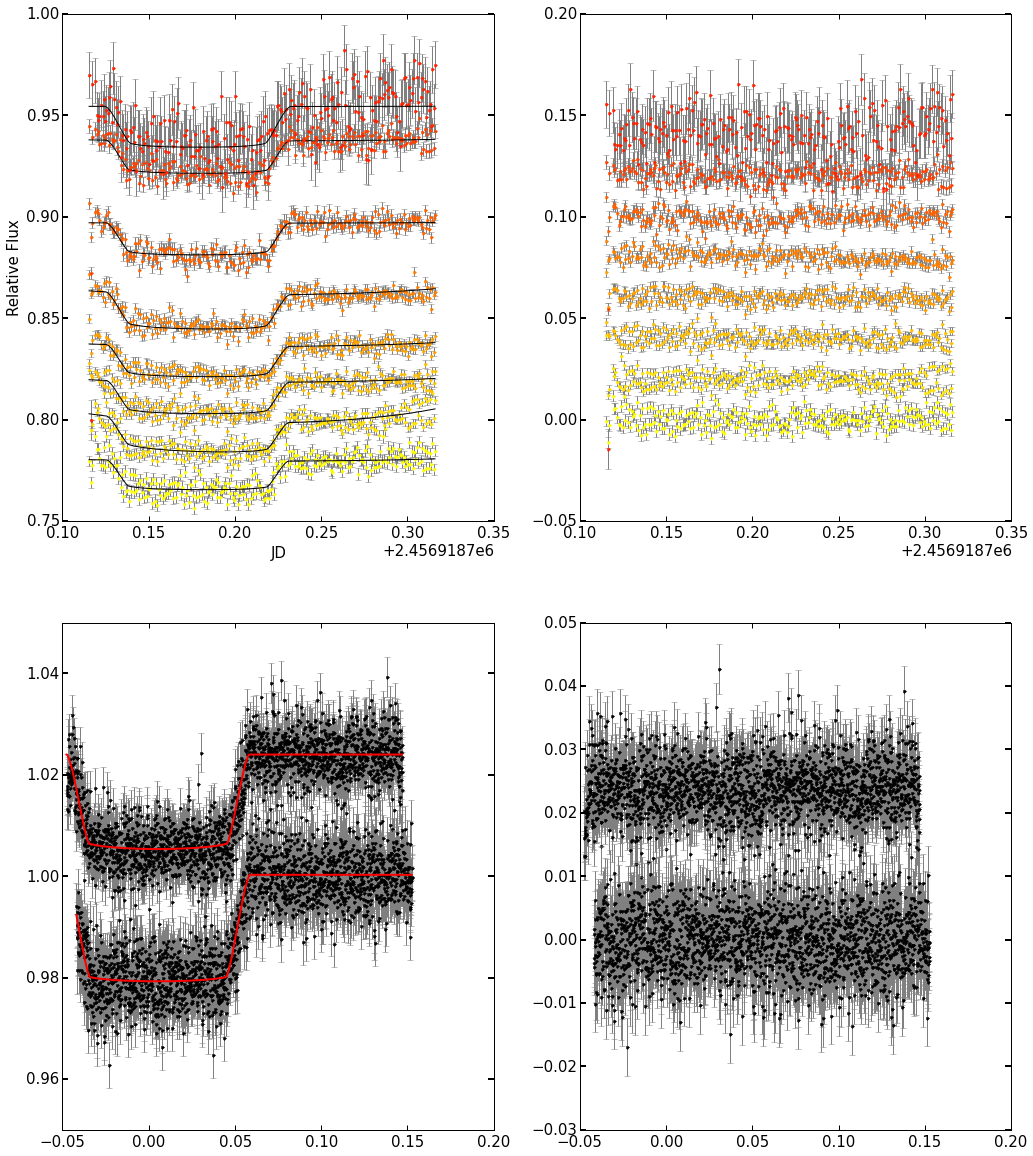

In [14]:
max_lnp_ind = np.argmax(lnp)
max_lnp_params = samples[max_lnp_ind,:]
cmap = plt.cm.autumn
mosfiremodel, ch1model, ch2model = genmodel(max_lnp_params)
fig, ax = plt.subplots(2, 2, figsize=(17,20))
for eachbin in range(len(lightcurve[0,:])):
    ax[0, 0].errorbar(times, lightcurve[:,eachbin] + eachbin*0.02, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0, 0].plot(times, mosfiremodel[:,eachbin] + eachbin*0.02, 'k')

    ax[0, 1].errorbar(times, lightcurve[:,eachbin] - mosfiremodel[:,eachbin] + eachbin*0.02, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    
ax[0, 0].set_xlabel('JD')
ax[0, 0].set_ylabel('Relative Flux')
    
for i, ch, model, phases in zip(range(2), [ch2, ch1], [ch2model, ch1model], [-182, -180]):
    ax[1, 0].errorbar(ch['t'] - t0_roughfit - phases*period, ch['f'] + i*0.024, yerr=ch['e'], 
                      fmt='.', color='k', ecolor='gray')
    ax[1, 0].plot(ch['t'] - t0_roughfit - phases*period, model + i*0.024, color='r', lw=2)
    
    ax[1, 1].errorbar(ch['t'] - t0_roughfit - phases*period, ch['f'] - model + i*0.024, yerr=ch['e'], 
                      fmt='.', color='k', ecolor='gray')
    
#ax[0].set_title('Init Params')
plt.show()

1.37995732


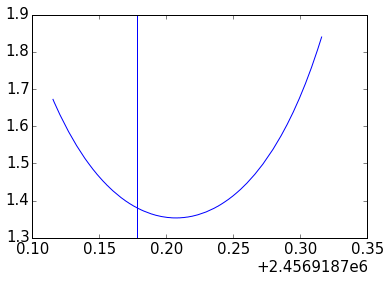

In [9]:
mosfiret0 = np.median(samples[:,2])
print airmass[np.argmin(np.abs(mosfiret0 - times))]
plt.plot(times, airmass)
plt.axvline(mosfiret0)

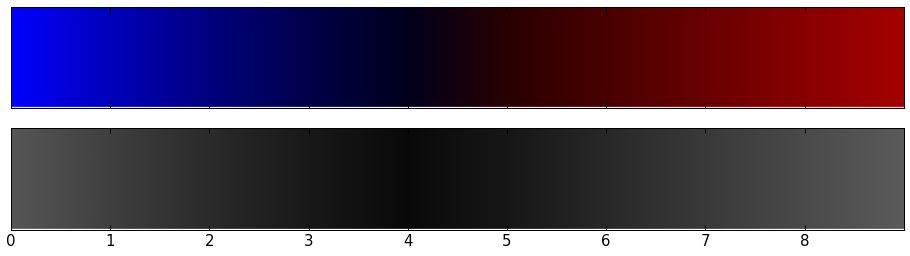

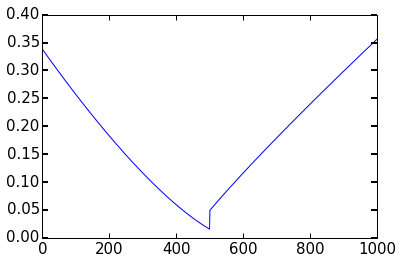

In [11]:
#Experimental colormap

# Custom black-to-red colormap
low = 0.1    # minimum contrast over black
high = 0.9  # maximum contrast over black
Nrows = 1000 # N interpolation points
blueexponent = 1.4 # Curve from black to color
redexponent = 0.9

reds = np.sqrt(np.concatenate([np.zeros(Nrows/2), np.linspace(low, high, Nrows/2)**redexponent])**2 /0.299)
greens = np.zeros(Nrows)
blues = np.sqrt(np.concatenate([np.linspace(high, low, Nrows/2)**blueexponent, np.zeros(Nrows/2)])**2 /0.114)

colormatrix = np.vstack([reds, greens, blues]).T
# for i in range(3):
#     if not (colormatrix[:,i] == 0).all():
#         colormatrix[:,i] /= np.max(colormatrix[:,i])

colormatrix /= np.max(colormatrix)

customcm = matplotlib.colors.ListedColormap(colormatrix)
fig, ax = plt.subplots(2, 1, figsize=(16,4), sharex='col')
ax[0].imshow(np.arange(10).reshape(1,10), cmap=customcm) # for example
ax[0].set_xlim([0,9])
ax[0].set_yticks([])
#plt.show()


def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    return matplotlib.colors.ListedColormap(colors), luminance

grayed, lum = grayify_cmap(customcm)
#fig = plt.figure(figsize=(16,2))
ax[1].imshow(np.arange(10).reshape(1,10), cmap=grayed) # for example
ax[1].set_xlim([0,9])
ax[1].set_yticks([])
ax[1].set_xticks(range(9))
plt.show()

plt.plot(lum)
plt.show()

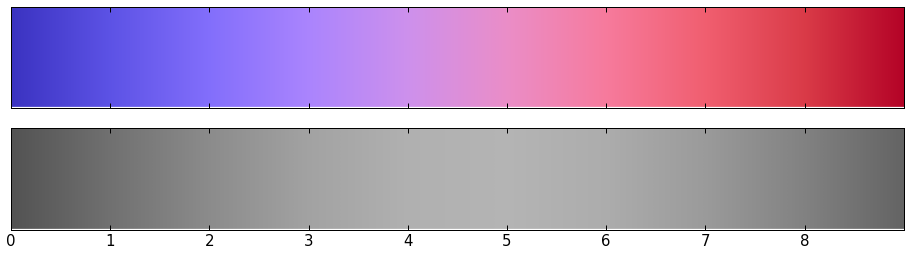

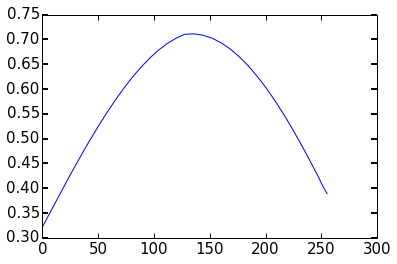

In [15]:
#Experimental colormap
colors = plt.cm.coolwarm(np.arange(cmap.N))[:,:3]#cm.coolwarm
colors[:,1] /= 1.5
customcm = matplotlib.colors.ListedColormap(colors)
#colors = cmap(np.arange(cmap.N))[:,:3]
#print colors 

#customcm = matplotlib.colors.ListedColormap(colormatrix)
fig, ax = plt.subplots(2, 1, figsize=(16,4), sharex='col')
ax[0].imshow(np.arange(10).reshape(1,10), cmap=customcm) # for example
ax[0].set_xlim([0,9])
ax[0].set_yticks([])
#plt.show()


def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    return matplotlib.colors.ListedColormap(colors), luminance

grayed, lum = grayify_cmap(customcm)
#fig = plt.figure(figsize=(16,2))
ax[1].imshow(np.arange(10).reshape(1,10), cmap=grayed) # for example
ax[1].set_xlim([0,9])
ax[1].set_yticks([])
ax[1].set_xticks(range(9))
plt.show()

plt.plot(lum)
plt.show()

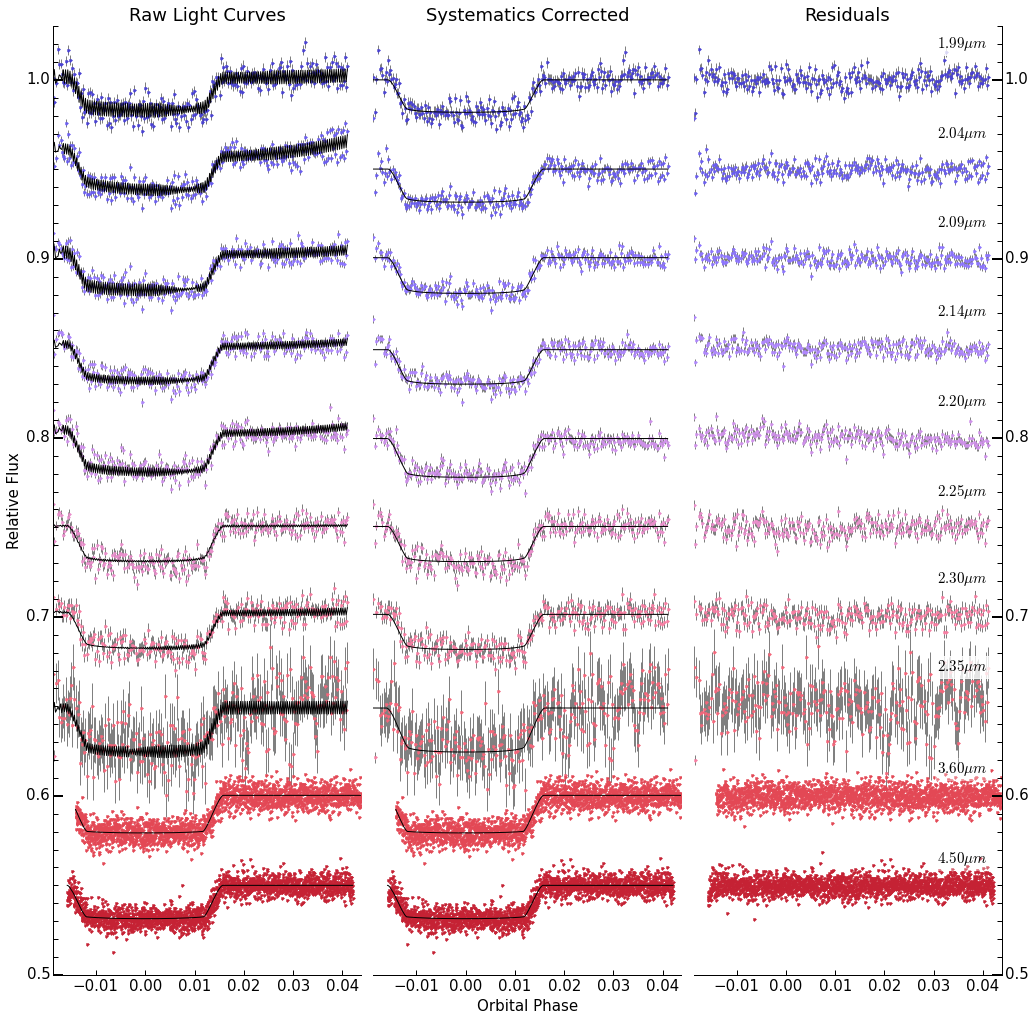

In [16]:
max_lnp_ind = np.argmax(lnp)
max_lnp_params = samples[max_lnp_ind,:]
cmap = plt.cm.autumn

mosfiremodel, ch1model, ch2model = genmodel(max_lnp_params)

tickwidth = 2
matplotlib.rcParams['xtick.major.size'] = 10/2
matplotlib.rcParams['xtick.major.width'] = tickwidth/2

matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = tickwidth
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.width'] = tickwidth/2

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
minorLocator   = MultipleLocator(0.01)

fig, ax = plt.subplots(1, 3, figsize=(17,17))#, dpi=500)

useparams = max_lnp_params
useparams = np.median(samples, axis=0)

gp_objs = []
kernellist = []
stimes = np.sort(times)
cosineperiod = 2*np.median(np.diff(stimes))
# for i in range(Nlightcurves):
#     # For MOSFIRE light curves:
#     if i < Nbins:

#mininttime = int(np.min(times))
bestmidtransit = np.median(samples[:,2])
mtimes = (times - bestmidtransit)/period
spreadfactor = -0.05

allphases = mtimes.tolist()
for eachbin in range(len(lightcurve[0,:])):
    # Gaussian process parameters
    w = np.exp(useparams[-2*Nbins-Nlightcurves+eachbin])
    amp = np.exp(useparams[-2*Nbins+eachbin])
    sig = useparams[-Nbins+eachbin]
    
    gp_obj = george.GP(amp*kernels.ExpSquaredKernel(sig)*kernels.CosineKernel(cosineperiod))
    gp_obj.compute(times, w**0.5)
    
    transitresiduals = lightcurve[:,eachbin] - mosfiremodel[:,eachbin]
    mu, cov = gp_obj.predict(transitresiduals, times)
    
    # Airmass correction
    am = np.exp(samples[max_lnp_ind,30+eachbin])
    amcorrection = 1 + (airmass - 1)/am # Divide data, model by this
    
    # Baseline flux correction
    F0 = np.median(samples[:,20+eachbin])
    
    errorbarstyle = dict(fmt='.', color=customcm((0.5 + eachbin)/ float(Nlightcurves)), 
                         ecolor='gray', capsize=0)
    # Raw light curves
    ax[0].errorbar(mtimes, lightcurve[:,eachbin]/F0 + eachbin*spreadfactor, \
                yerr=lightcurve_errors[:,eachbin], **errorbarstyle)
    ax[0].plot(mtimes, (mosfiremodel[:,eachbin] + mu)/F0 + eachbin*spreadfactor, 'k')

    # Systematics corrected
    ax[1].errorbar(mtimes, (lightcurve[:,eachbin] - mu)/amcorrection/F0 + eachbin*spreadfactor, \
                yerr=lightcurve_errors[:,eachbin], **errorbarstyle)
    ax[1].plot(mtimes, mosfiremodel[:,eachbin]/amcorrection/F0 + eachbin*spreadfactor, 'k')

    #ax[1].plot(times, mu + eachbin*spreadfactor, 'k')

    # GP, transit subtracted
    gptransitsubtracted = (transitresiduals - mu)/F0 + eachbin*spreadfactor + 1
    ax[2].errorbar(mtimes, gptransitsubtracted, \
                yerr=lightcurve_errors[:,eachbin], **errorbarstyle)

    # Label:
    ax[2].annotate('${0:.2f} \mu m$'.format(wavelengthbincenters[eachbin]),
                   (np.max(mtimes), np.median(gptransitsubtracted)+0.015), 
                   ha='right', va='bottom', 
                   bbox=dict(facecolor='w', alpha=0.8,edgecolor='w'))
    
# Plot spitzer light curves
for i, ch, model, Nphases, lam in zip(range(2), [ch2, ch1], [ch2model, ch1model], [-182, -180], [3.6, 4.5]):
    eachbin += 1
    errorbarstyle = dict(fmt=',', color=customcm((0.5 + eachbin)/ float(Nlightcurves)), 
                     ecolor='gray', capsize=0)
    spitzerformat = '.'
    
    phase = (ch['t'] - np.median(samples[:,3]))/period - Nphases
    allphases.extend(phase.tolist())
#     ax[0].errorbar(phase, ch['f']  + eachbin*spreadfactor, yerr=ch['e'], 
#                       **errorbarstyle)
    ax[0].plot(phase, ch['f']  + eachbin*spreadfactor, spitzerformat,
               color=customcm((0.5 + eachbin)/ float(Nlightcurves)))
    ax[0].plot(phase, model + eachbin*spreadfactor , color='k', lw=1)
    
#     ax[1].errorbar(phase, ch['f']  + eachbin*spreadfactor, yerr=ch['e'], 
#                       **errorbarstyle)
    ax[1].plot(phase, ch['f']  + eachbin*spreadfactor, spitzerformat,
               color=customcm((0.5 + eachbin)/ float(Nlightcurves)))
    
    ax[1].plot(phase, model + eachbin*spreadfactor, color='k', lw=1)

    ax[2].plot(phase, ch['f'] - model + eachbin*spreadfactor + 1, spitzerformat,
               color=customcm((0.5 + eachbin)/ float(Nlightcurves)))
#     ax[2].errorbar(phase, ch['f'] - model + eachbin*spreadfactor + 1, yerr=ch['e'], 
#                       **errorbarstyle)
 
    ax[2].annotate('${0:.2f} \mu m$'.format(lam),
                   (np.max(mtimes), np.median(ch['f'] - model + eachbin*spreadfactor + 1)+0.01), 
                   ha='right', va='bottom',
                  bbox=dict(facecolor='w', alpha=0.3,edgecolor='w'))
    
ax[1].set_xlabel('Orbital Phase')
ax[0].set_ylabel('Relative Flux')

ax[0].set_title('Raw Light Curves')
ax[1].set_title('Systematics Corrected')
ax[2].set_title('Residuals')


fig.savefig('plots/mosfiresystematics.pdf',bbox_inches='tight')
#ax[0].set_title('Init Params')

for i in range(3):
    ax[i].set_xlim([np.min(allphases), np.max(allphases)])
    ax[i].set_ylim([0.5, 1.03])

    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].spines['top'].set_visible(False)
    
    if i == 0:
        ax[i].yaxis.set_ticks_position('left')
        ax[i].yaxis.set_minor_locator(minorLocator)

    if i in [0, 1]:
        ax[i].spines['right'].set_visible(False)

    if i in [1, 2]:
        ax[i].spines['left'].set_visible(False)

    if i == 1:
        ax[i].set_yticks([])

    if i == 2:
        #ax[i].yaxis.set_label_position("right")
        ax[i].yaxis.tick_right()
        ax[i].yaxis.set_minor_locator(minorLocator)
    
fig.subplots_adjust(wspace=0.04)
#savecopies(fig, 'lc')
plt.show()

In [17]:
# def autocorr(x):
#     result = np.correlate(x, x, mode='full')
#     return result[result.size/2:]

# matplotlib.rcParams['ytick.major.size'] = 6
# fig, ax = plt.subplots(Nbins, 2, figsize=(16,16), sharey='row', sharex='col')
# gp_objs = []
# kernellist = []
# stimes = np.sort(times)
# cosineperiod = 2*np.median(np.diff(stimes))

# bestmidtransit = np.median(samples[:,2])
# mtimes = (times - bestmidtransit)/period
# spreadfactor = -0.05

# allphases = mtimes.tolist()
# for eachbin in range(len(lightcurve[0,:])):
#     # Gaussian process parameters
#     w = np.exp(useparams[-2*Nbins-Nlightcurves+eachbin])
#     amp = np.exp(useparams[-2*Nbins+eachbin])
#     sig = useparams[-Nbins+eachbin]
    
#     gp_obj = george.GP(amp*kernels.ExpSquaredKernel(sig)*kernels.CosineKernel(cosineperiod))
#     gp_obj.compute(times, w**0.5)
    
#     transitresiduals = lightcurve[:,eachbin] - mosfiremodel[:,eachbin]
#     mu, cov = gp_obj.predict(transitresiduals, times)
    
#     # Airmass correction
#     am = np.exp(samples[max_lnp_ind,30+eachbin])
#     amcorrection = 1 + (airmass - 1)/am # Divide data, model by this
    
#     # Baseline flux correction
#     F0 = np.median(samples[:,20+eachbin])
#     errorbarstyle = dict(fmt='.', color=customcm((0.5 + eachbin)/ float(Nlightcurves)), 
#                          ecolor='gray', capsize=0)
#     # Raw light curves
#     ax[eachbin, 0].plot(autocorr(transitresiduals), 'k')
#     #ax[0].plot(mtimes, (mosfiremodel[:,eachbin] + mu)/F0 + eachbin*spreadfactor, 'k')


#     gptransitsubtracted = autocorr(transitresiduals - mu) #+ eachbin*spreadfactor + 1
#     ax[eachbin, 1].plot(gptransitsubtracted, 'k')

#     # Labels and limit
#     for i in range(2):
#         ax[eachbin, i].set_ylim([-0.004, 0.004])
#         ax[eachbin, i].set_xlim([-10, 270])
#         xticks = np.arange(0, 275, 50)
#         ax[eachbin, i].set_xticks(xticks)
#         yticks = np.arange(-0.004, 0.006, 0.002)
#         ax[eachbin, i].set_yticks(yticks)
#         [tick.label.set_fontsize(12) for tick in ax[eachbin, i].yaxis.get_major_ticks()]
#         ax[eachbin, i].annotate('${0:.2f} \mu m$'.format(wavelengthbincenters[eachbin]),
#                        (0.95, 0.7), xycoords='axes fraction', 
#                        ha='right', va='bottom', 
#                        bbox=dict(facecolor='w', alpha=0.8,edgecolor='w'))
        
# fig.subplots_adjust(wspace=0)

# ax[0, 0].set_title('Raw Residuals')
# ax[0, 1].set_title('Gaussian Process Removed')

# bigax = fig.add_subplot(111)
# bigax.set_ylabel('Autocorrelation', fontsize=18)
# bigax.set_xlabel('Time lag [exposures]', fontsize=18)

# sides = ['left', 'right', 'top', 'bottom']
# for side in sides: 
#     bigax.spines[side].set_visible(False)
# bigax.set_xticks([])
# bigax.set_yticks([])

# bigax.xaxis.set_label_coords(0.5, -0.04)
# bigax.yaxis.set_label_coords(-0.07, 0.5)

# savecopies(fig, 'autocorr')
# plt.show()

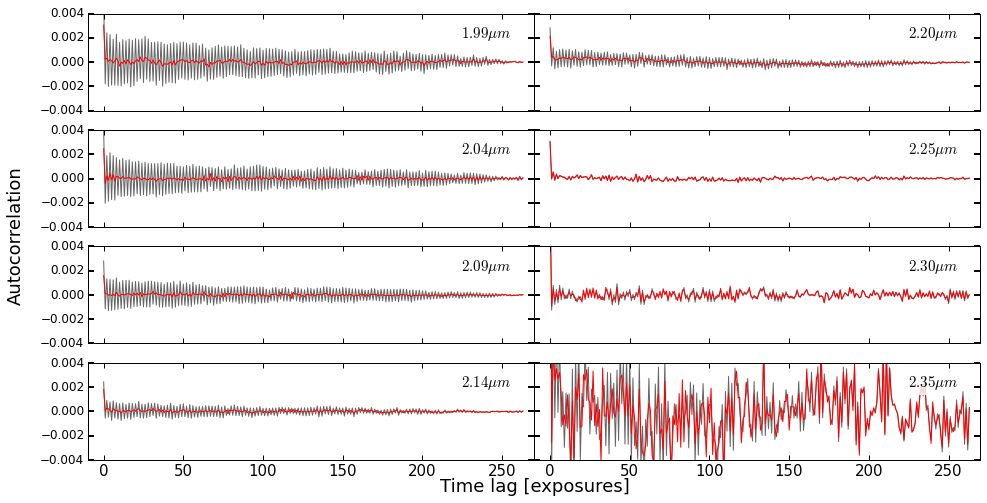

In [25]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

matplotlib.rcParams['ytick.major.size'] = 6
fig, ax = plt.subplots(Nbins/2, 2, figsize=(16,8), sharey='row', sharex='col')
gp_objs = []
kernellist = []
stimes = np.sort(times)
cosineperiod = 2*np.median(np.diff(stimes))

bestmidtransit = np.median(samples[:,2])
mtimes = (times - bestmidtransit)/period
spreadfactor = -0.05

allphases = mtimes.tolist()
for eachbin in range(len(lightcurve[0,:])):
    # Gaussian process parameters
    w = np.exp(useparams[-2*Nbins-Nlightcurves+eachbin])
    amp = np.exp(useparams[-2*Nbins+eachbin])
    sig = useparams[-Nbins+eachbin]
    
    gp_obj = george.GP(amp*kernels.ExpSquaredKernel(sig)*kernels.CosineKernel(cosineperiod))
    gp_obj.compute(times, w**0.5)
    
    transitresiduals = lightcurve[:,eachbin] - mosfiremodel[:,eachbin]
    mu, cov = gp_obj.predict(transitresiduals, times)
    
    # Airmass correction
    am = np.exp(samples[max_lnp_ind,30+eachbin])
    amcorrection = 1 + (airmass - 1)/am # Divide data, model by this
    
    xplotind = 0 if eachbin < 4 else 1
    yplotind = eachbin if eachbin < 4 else eachbin - 4
    # Baseline flux correction
    F0 = np.median(samples[:,20+eachbin])
    errorbarstyle = dict(fmt='.', color=customcm((0.5 + eachbin)/ float(Nlightcurves)), 
                         ecolor='gray', capsize=0)
    # Raw light curves
    ax[yplotind, xplotind].plot(autocorr(transitresiduals), '#666666')
    #ax[0].plot(mtimes, (mosfiremodel[:,eachbin] + mu)/F0 + eachbin*spreadfactor, 'k')


    gptransitsubtracted = autocorr(transitresiduals - mu) #+ eachbin*spreadfactor + 1
    ax[yplotind, xplotind].plot(gptransitsubtracted, color='r')

    # Labels and limit
    #for i in range(2):
    ax[yplotind, xplotind].set_ylim([-0.004, 0.004])
    ax[yplotind, xplotind].set_xlim([-10, 270])
    xticks = np.arange(0, 275, 50)
    ax[yplotind, xplotind].set_xticks(xticks)
    yticks = np.arange(-0.004, 0.006, 0.002)
    ax[yplotind, xplotind].set_yticks(yticks)
    [tick.label.set_fontsize(12) for tick in ax[yplotind, xplotind].yaxis.get_major_ticks()]
    ax[yplotind, xplotind].annotate('${0:.2f} \mu m$'.format(wavelengthbincenters[eachbin]),
                   (0.95, 0.7), xycoords='axes fraction', 
                   ha='right', va='bottom', 
                   bbox=dict(facecolor='w', alpha=0.8,edgecolor='w'))
        
fig.subplots_adjust(wspace=0)

#ax[0, 0].set_title('Raw Residuals')
#ax[0, 1].set_title('Gaussian Process Removed')

bigax = fig.add_subplot(111)
bigax.set_ylabel('Autocorrelation', fontsize=18)
bigax.set_xlabel('Time lag [exposures]', fontsize=18)

sides = ['left', 'right', 'top', 'bottom']
for side in sides: 
    bigax.spines[side].set_visible(False)
bigax.set_xticks([])
bigax.set_yticks([])

bigax.xaxis.set_label_coords(0.5, -0.04)
bigax.yaxis.set_label_coords(-0.07, 0.5)

savecopies(fig, 'autocorr')
plt.show()

In [157]:
print ch['f'] - model + eachbin*spreadfactor

[-0.63353655 -0.63778992 -0.64061301 ..., -0.62804509 -0.63323534
 -0.63686355]


## Parameters linked between all spectral bins

# Results

In [28]:
with open('MOSFIREresults.txt', 'w') as f:
    for eachbin in range(Nbins):
        s = '{0:.4f} {1:.4f} {2:.4f} {3:.4f} {4:.4f}'.format(
                wavelengthbounds[eachbin][0],wavelengthbounds[eachbin][1], *medplusminus(samples[:,10+eachbin]))
        print s
        f.write(s+'\n')


1.9620 2.0141 0.1351 0.0023 0.0024
2.0141 2.0662 0.1337 0.0018 0.0018
2.0662 2.1182 0.1357 0.0018 0.0019
2.1182 2.1703 0.1361 0.0018 0.0019
2.1703 2.2224 0.1370 0.0018 0.0018
2.2224 2.2745 0.1431 0.0019 0.0019
2.2745 2.3265 0.1362 0.0025 0.0024
2.3265 2.3786 0.1394 0.0071 0.0071


# Candidate Spectrum

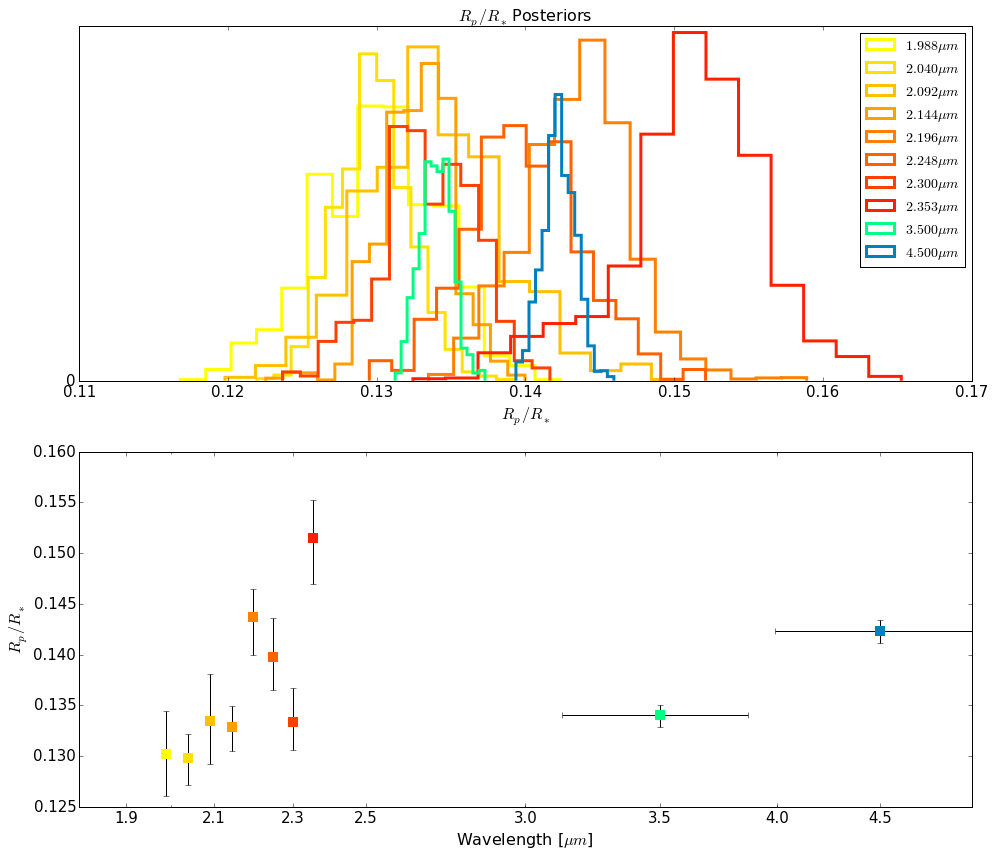

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(16,14))
histbins = 15
nikolovdata = np.loadtxt('../leftnod/nikolov.dat')
def medplusminus(vector):
    v = np.percentile(vector, [16, 50, 84])
    return v[1], v[2]-v[1], v[1]-v[0]

def depthhist(ax, eachbin, cmap=plt.cm.autumn):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    RpRs = samples[:,10+eachbin]
    ax[0].hist(RpRs, histbins, histtype='step', \
               
               label='$%.3f\mu m$' % wavelengthbincenters[eachbin],\
               color=cmap(1 - i/float(len(wavelengthbincenters))), lw=3)
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,10+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    ax[1].errorbar(wavelengthbincenters[eachbin], bestRpRs, yerr=[[bestRpRsminus], [bestRpRsplus]], \
                  fmt='s', color=cmap(1 - i/float(len(wavelengthbincenters))), \
                  ecolor='k', markeredgecolor='none', ms=10)

binwidth_nik = 0.5*(nikolovdata[:,1]-nikolovdata[:,0])*1e-4

def depthhistspitz(ax, eachbin, cmap=plt.cm.winter):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    wavelengthbincenters_spitz = [3.5, 4.5]

    RpRs = samples[:,18+eachbin]
    ax[0].hist(RpRs, histbins, histtype='step', \
               
               label='$%.3f\mu m$' % wavelengthbincenters_spitz[eachbin],\
               color=cmap(1 - i/float(len(wavelengthbincenters_spitz))), lw=3)
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,18+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    ax[1].errorbar(wavelengthbincenters_spitz[eachbin], bestRpRs, 
                xerr=[binwidth_nik[-2:][eachbin]], yerr=[[bestRpRsminus], [bestRpRsplus]], 
                  fmt='s', color=cmap(1 - i/float(len(wavelengthbincenters_spitz))), 
                  ecolor='k', markeredgecolor='none', ms=10)
    
for i in range(Nbins):
    depthhist(ax, i)
    
for i in range(2):
    depthhistspitz(ax, i)
    
ax[0].legend(fontsize=14)
ax[0].set_xlabel(r'$R_p/R_*$', fontsize=16)
ax[0].set_title(r'$R_p/R_*$ Posteriors',fontsize=16)
ax[0].set_yticks([0])

ax[1].set_xscale('log')

ax[1].set_xlabel('Wavelength [$\mu m$]', fontsize=16)
ax[1].set_ylabel(r'$R_p/R_*$', fontsize=16)

ax[1].set_xlim([1.8, 5])
xticks = [1.9, 2.1, 2.3, 2.5, 3.0, 3.5, 4.0, 4.5]
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(map("{0}".format, xticks))

plt.show()

## Comparison with [Jordan et al. (2013)](http://adsabs.harvard.edu/abs/2013ApJ...778..184J) and [Nikolov et al. (2014)](http://arxiv.org/abs/1411.4567)

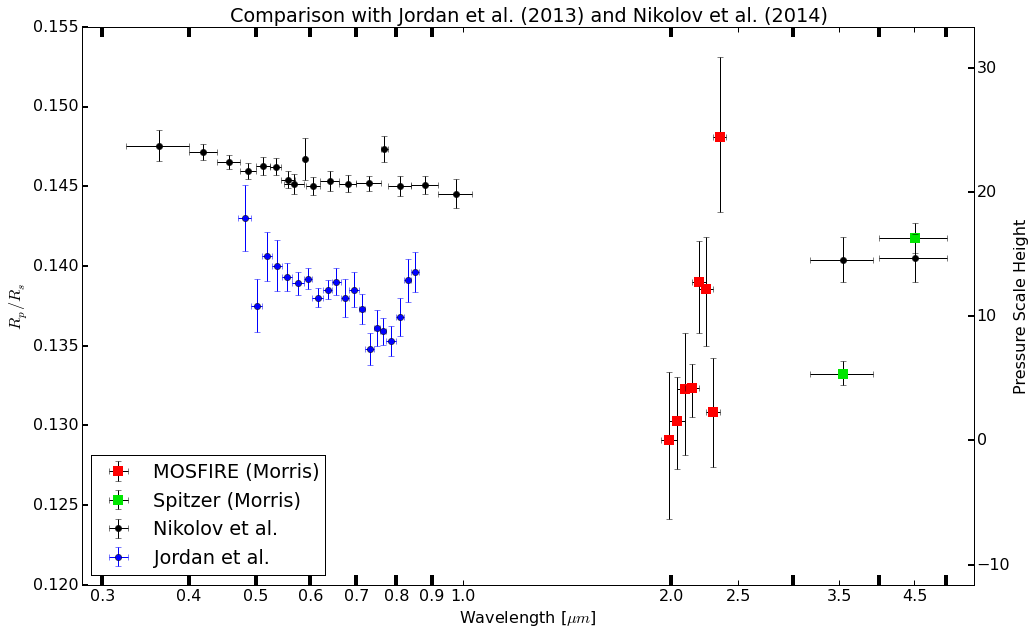

In [261]:
# MOSFIRE binwidth 
#mosfirebinwidth = 0.5*(wavelengthbincenters[1] - wavelengthbincenters[0])

# Read in Nikolov data
nikolovdata = np.loadtxt('../leftnod/nikolov.dat')
wave_nik = np.mean([nikolovdata[:,0],nikolovdata[:,1]],axis=0)*1e-4
binwidth_nik = 0.5*(nikolovdata[:,1]-nikolovdata[:,0])*1e-4
RpRs_nik = nikolovdata[:,2]
RpRsUnc_nik = nikolovdata[:,3]

# Read in Jordan data
jordandata = np.loadtxt('../leftnod/jordan.dat')
wave_jordan = np.mean([jordandata[:,0],jordandata[:,1]],axis=0)*1e-4
binwidth_jordan = 0.5*(jordandata[:,1]-jordandata[:,0])*1e-4
RpRs_jordan = jordandata[:,2]
RpRsUnc_jordan = np.mean([jordandata[:,3],np.abs(jordandata[:,4])],axis=0)

def depthhist(ax, eachbin):
    RpRs = samples[:,10+eachbin]
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,10+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)
    binwidth = wavelengthbincenters[1]-wavelengthbincenters[0]
    if eachbin == 0:
        kwargs = {'label' : 'MOSFIRE (Morris)'}
    else: 
        kwargs = {}
    ax.errorbar(wavelengthbincenters[eachbin], bestRpRs, xerr=[[binwidth], [binwidth]],
                 yerr=[[bestRpRsminus], [bestRpRsplus]], \
                  fmt='s', color='r', ecolor='k', markeredgecolor='none', ms=10, **kwargs)
    #color=cmap(1 - i/float(len(wavelengthbincenters))), \
    return bestRpRs

def depthhistspitz(ax, eachbin, cmap=plt.cm.winter):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    wavelengthbincenters_spitz = wave_nik[-2:]#[3.5, 4.5]

    RpRs = samples[:,18+eachbin]
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,18+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    if eachbin == 0:
        kwargs = {'label' : 'Spitzer (Morris)'}
    else: 
        kwargs = {}
    ax.errorbar(wavelengthbincenters_spitz[eachbin], bestRpRs, 
                xerr=[binwidth_nik[-2:][eachbin]], yerr=[[bestRpRsminus], [bestRpRsplus]], 
                  fmt='s', color='#00E600', ecolor='k', markeredgecolor='none', ms=10, **kwargs)
    return bestRpRs
    #color=cmap(1 - i/float(len(wavelengthbincenters_spitz))),

matplotlib.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, figsize=(16,10))

# Plot MOSFIRE
radii = []
waves = np.concatenate((wavelengthbincenters, wave_nik[-2:]))
for i in range(Nbins):
    radii.append(depthhist(ax, i))

# Plot Spitzer
for i in range(2):
    radii.append(depthhistspitz(ax, i))

# Plot Nikolov, Jordan
ax.errorbar(wave_nik, RpRs_nik, yerr=RpRsUnc_nik, xerr=binwidth_nik, fmt='o', color='k', label='Nikolov et al.')
ax.errorbar(wave_jordan, RpRs_jordan, yerr=RpRsUnc_jordan, xerr=binwidth_jordan, fmt='o', color='b', label='Jordan et al.')

## Calculate Rp/Rs -> pressure scale heights
from astropy.constants import G, k_B, M_jup, m_p, R_sun
from astropy import units as u

def scaleheights(RpRs):
    '''
    Compute scale heights at deepest radius, then return Nscaleheights for
    each radius.
    '''
    minRpRs = np.min(RpRs)
    Rs = 0.870*R_sun                # Gillon 2009
    Mp = 0.503*M_jup                # Gillon 2009
    minRp = minRpRs*Rs
    g = G*Mp/(minRp**2)
    mu = 2*m_p                      # Assuming H2 dominated atmos
    T = 1194                        # Gillon 2009
    minH = ( k_B*T/(mu*g) ).value

    #allRp = np.array([(RpRs_i*Rs).value for RpRs_i in RpRs])
    #Hs = [(Rp_i-minRp.value)/minH for Rp_i in allRp]
    Hs = lambda allRpRs: [((RpRs_i*Rs).value-minRp.value)/minH for RpRs_i in allRpRs]
    return Hs


initxlim = ax.get_xlim()
initylim = ax.get_ylim()

Hs = scaleheights(radii)
ax2 = ax.twinx()
ax2.plot(waves, Hs(radii), ',', alpha=0)
#ax2.set_xlim(initxlim)
ax2.set_ylim(Hs(initylim))
ax2.set_ylabel('Pressure Scale Height')

for axis in [ax, ax2]:
    axis.set_xlim([0.28, 5.5])
    axis.set_xscale("log")
    xticklist = np.arange(0.3, 1.1, 0.1).tolist() + [2.0, 2.5, 3.5, 4.5]
    axis.set_xticks(xticklist)
    axis.set_xticklabels(map(lambda x: '%.1f' % x, xticklist))
ax.set_title('Comparison with Jordan et al. (2013) and Nikolov et al. (2014)')

ax.set_ylabel('$R_p/R_s$')
ax.set_xlabel('Wavelength [$\mu m$]')
ax.legend(loc='lower left', numpoints=1)
fig.savefig('plots/comparison.png', bbox_inches='tight')
plt.show()

In [204]:
paddingbounds = [110, 2130]
spectralbinbounds = np.linspace(paddingbounds[0], paddingbounds[1], Nbins+1, dtype=int)
print spectralbinbounds

firstlines = \
'''
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
physical
'''

# Box format:
# centerx centery widthx widthy rot
with open('binregions.reg','w') as reg:
    for i in range(len(spectralbinbounds)-1):
        centerx =  0.5*(spectralbinbounds[i] + spectralbinbounds[i+1])
        centery = 2024/2
        widthx = spectralbinbounds[i+1] - spectralbinbounds[i]
        widthy = 2024
        angle = 0
        linewidth = 3
        wavelength = wavelengthbincenters[i]
        reg.write("box({0:f},{1:f},{2:f},{3:f},{4:f}) # width={5} text={{{6:.3f}}} \n".format(
                  centerx, centery, widthx, widthy, angle, linewidth, wavelength))

[ 110  312  514  716  918 1120 1322 1524 1726 1928 2130]


## Compare MOSFIRE+Spitzer fits with TAP Spitzer fits

[[ 0.13125788  0.0026918   0.00256984]
 [ 0.14156172  0.00189539  0.00204403]]


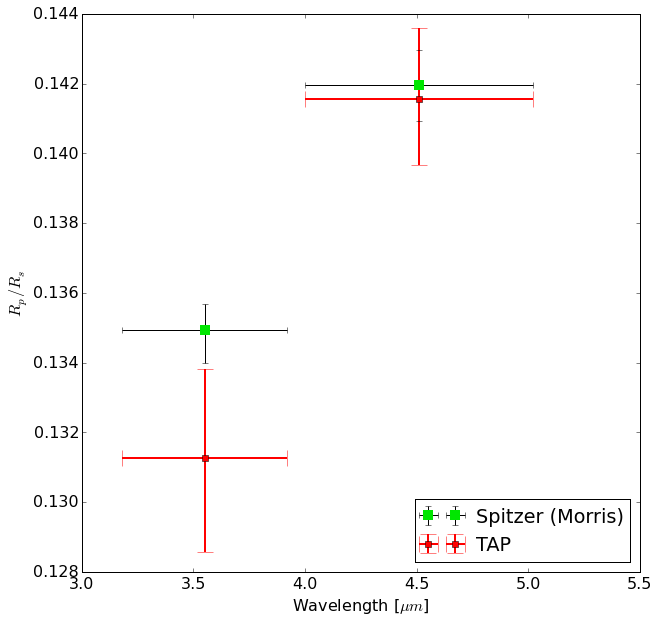

In [78]:
tapresults = np.loadtxt('TAP/TAPmcmc_20150202_1113/RpRsTAP.txt')

print tapresults
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(2):
    depthhistspitz(ax, i)
    
ax.errorbar(wave_nik[-2:], tapresults[:,0], xerr=[binwidth_nik[-2:], binwidth_nik[-2:]],
            yerr=[tapresults[:,1], tapresults[:,2]], fmt='s', color='r', elinewidth=2, capsize=8, label='TAP')
ax.legend(loc='lower right')
ax.set_ylabel('$R_p/R_s$')
ax.set_xlabel('Wavelength [$\mu m$]')
plt.show()

## Light curves and residuals

In [59]:
matplotlib.rcParams['font.size'] = 30
Nbins = np.shape(lightcurve)[1]

mosfiremodel,_,_ = genmodel(max_lnp_params)
model = mosfiremodel
mintimeint = int(np.min(times))
cmap = plt.cm.autumn
spread = 0.05
t0_roughfit = 2456918.8793039066
t14duration_expected = 0.1086 # days

fig, ax = plt.subplots(1, 2, figsize=(40,22))
#ax[0].tick_params(axis='y', which='both', labelleft='on', labelright='on')

ax1 = fig.add_subplot(121, frameon=False)#sharey=ax[1],
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
ax1.set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters))
ax1.set_xticks([])

ax2 = fig.add_subplot(111, frameon=False)#sharey=ax[1],
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
ax2.set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters))
ax2.set_xticks([])


for eachbin in range(len(lightcurve[0,:])):
    oot = (times < t0_roughfit - t14duration_expected/2.0) + \
          (times > t0_roughfit + t14duration_expected/2.0)
    bestF0 = np.mean(lightcurve[:,eachbin][oot])
    lc = lightcurve[:,eachbin]/bestF0 + eachbin*spread
    modellc = model[:,eachbin]/bestF0 + eachbin*spread
    ax[0].errorbar(times - mintimeint, lc, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0].plot(times - mintimeint, modellc, 'k')

    ax[0].errorbar(times - mintimeint, lc, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0].plot(times - mintimeint, modellc, 'k')

    ax[1].errorbar(times - mintimeint, lc - modellc  + eachbin*spread + 1, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[1].plot(times - mintimeint, np.zeros_like(modellc) + eachbin*spread + 1, \
                color='k')
    
ax[0].set_ylabel('Relative Flux')    
#ax[0].set_ylim([0.95, 1.50])
ax2.set_ylim([0.95, 1.40])
ax1.set_ylim([0.95, 1.40])

ax[1].set_ylabel('Residuals')    
#ax.grid()
for i in [0,1]:
    ax[i].set_xlabel('JD - %d' % mintimeint)
    ax[i].set_xlim([0.8, 1.03])
    ax[i].set_ylim([0.95, 1.40])
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].yaxis.set_ticks_position('left')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[0].set_title('Max $\log p$ Light Curves')
fig.subplots_adjust(wspace=0.3)
#fig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/max_lnp_lightcurves_poster.eps', bbox_inches='tight')
plt.show()

NameError: name 'max_lnp_params' is not defined

## Light curves and residuals and Photon noise


## Light curves and residuals and Photon noise  and using grispec

In [ ]:
matplotlib.rcParams['font.size'] = 30
Nbins = np.shape(lightcurve)[1]
#model = genmodel(max_lnp_params)
mintimeint = int(np.min(times))
cmap = customcm
spread = 0.05
t0_roughfit = 2456918.8793039066
t14duration_expected = 0.1086 # days

#fig, ax = plt.subplots(1, 3, figsize=(50,22))
fig = plt.figure(figsize=(40,22))
gs = gridspec.GridSpec(1, 9)
ax1 = plt.subplot(gs[0, 0:4])
ax2 = plt.subplot(gs[0, 4:8])
ax3 = plt.subplot(gs[0, 8])
ax = [ax1, ax2, ax3] 
#ax[0].tick_params(axis='y', which='both', labelleft='on', labelright='on')

# ax1 = fig.add_subplot(194, frameon=False)#sharey=ax[1],
# ax1.yaxis.tick_right()
# ax1.yaxis.set_label_position("right")
# ax1.set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
# ax1.set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters[::-1]))
# ax1.set_xticks([])

ax2 = fig.add_subplot(199, frameon=False)#sharey=ax[1],
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
ax2.set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters[::-1]))
ax2.set_xticks([])


for eachbin, offset in zip(range(len(lightcurve[0,:])), range(len(lightcurve[0,:]))[::-1]):
    oot = (times < t0_roughfit - t14duration_expected/2.0) + \
          (times > t0_roughfit + t14duration_expected/2.0)
    bestF0 = np.mean(lightcurve[:,eachbin][oot])
    lc = lightcurve[:,eachbin]/bestF0 + offset*spread
    modellc = model[:,eachbin]/bestF0 + offset*spread
    ax[0].errorbar(times - mintimeint, lc, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0].plot(times - mintimeint, modellc, 'k')

    ax[0].errorbar(times - mintimeint, lc, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0].plot(times - mintimeint, modellc, 'k')

    ax[1].errorbar(times - mintimeint, lc - modellc  + offset*spread + 1, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[1].plot(times - mintimeint, np.zeros_like(modellc) + eachbin*spread + 1, \
                color='k')
    
ax[2].plot(Nphotonnoise, wavelengthbincenters[::-1], 'ks', markersize=10)
#ax[2].set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
ax[2].set_yticks(wavelengthbincenters)
#ax[2].set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters))
ax[2].set_yticklabels([])
ax[2].set_ylim([1.935, 2.405])
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].set_xticks(np.arange(1.1, 2.2, 0.3))
ax[2].set_xlabel('rms / photon noise', fontsize=35)

#ax[0].set_ylabel('Relative Flux')    
ax[1].set_yticklabels([])

ax2.set_ylim([0.95, 1.40])
ax1.set_ylim([0.95, 1.40])
#ax[1].set_ylabel('Residuals')    
#ax.grid()
for i in [0,1]:
    ax[i].set_xlabel('JD - %d' % mintimeint)
    ax[i].set_xlim([0.8, 1.02])
    ax[i].set_ylim([0.95, 1.40])
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].yaxis.set_ticks_position('left')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[0].set_title('Max $\log p$ Light Curves')
fig.subplots_adjust(wspace=0.2)

#fig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/max_lnp_lightcurves_photonnoise_poster.eps', bbox_inches='tight')
plt.show()

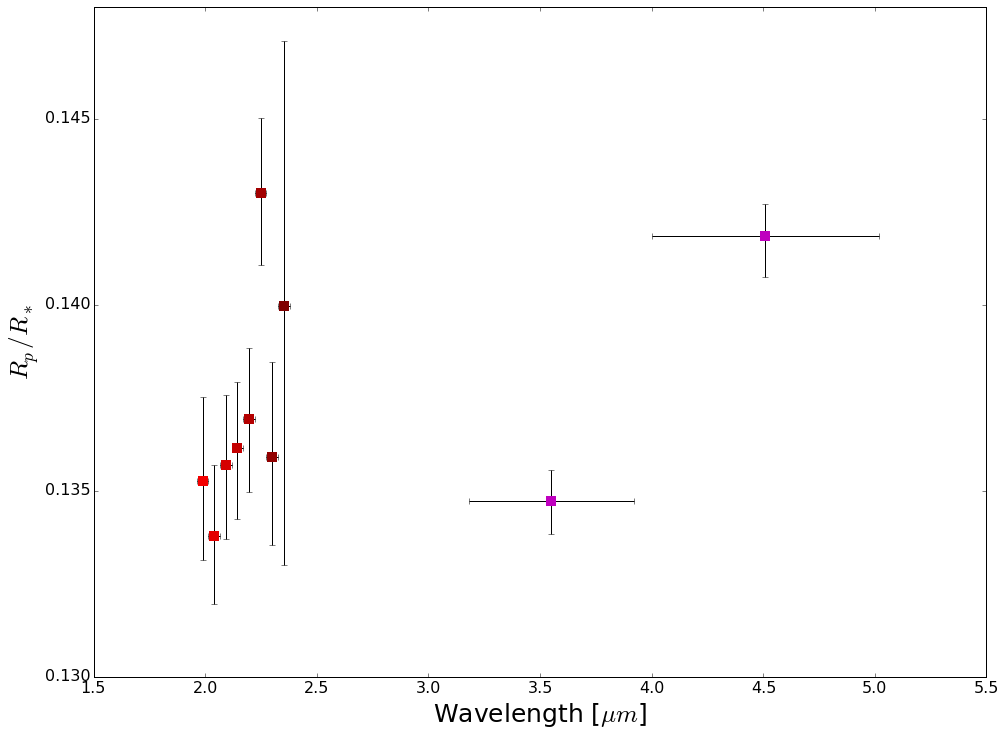

In [630]:
matplotlib.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, figsize=(16,12))
histbins = 15

def depthhist(ax, eachbin):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    RpRs = samples[:,10+eachbin]
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,10+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    ax.errorbar(wavelengthbincenters[eachbin], bestRpRs, yerr=[[bestRpRsminus], [bestRpRsplus]], \
                  fmt='s', color=cmap(1 - i/float(len(wavelengthbincenters))), \
                  ecolor='k', markeredgecolor='none', ms=10)
    return bestRpRs, bestRpRsplus, bestRpRsminus
    
def depthhistspitz(ax, eachbin, cmap=plt.cm.winter):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    wavelengthbincenters_spitz = wave_nik[-2:]#[3.5, 4.5]

    RpRs = samples[:,18+eachbin]
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,18+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    ax.errorbar(wavelengthbincenters_spitz[eachbin], bestRpRs, 
                xerr=[binwidth_nik[-2:][eachbin]], yerr=[[bestRpRsminus], [bestRpRsplus]], 
                  fmt='s', color='m',
                  ecolor='k', markeredgecolor='none', ms=10)
    #color=cmap(1 - i/float(len(wavelengthbincenters_spitz))),
    
spectrum = []
for i in range(Nbins):
    spectrum.append(depthhist(ax, i))
    
for i in range(2):
    spectrum.append(depthhistspitz(ax, i))
    
np.save('spectrum.npy',spectrum)
    
labelsize = 25
ax.set_xlabel('Wavelength [$\mu m$]', fontsize=labelsize)
ax.set_ylabel(r'$R_p/R_*$', fontsize=labelsize)
#fig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/simplespectrum.eps', bbox_inches='tight')
plt.show()

26573 64


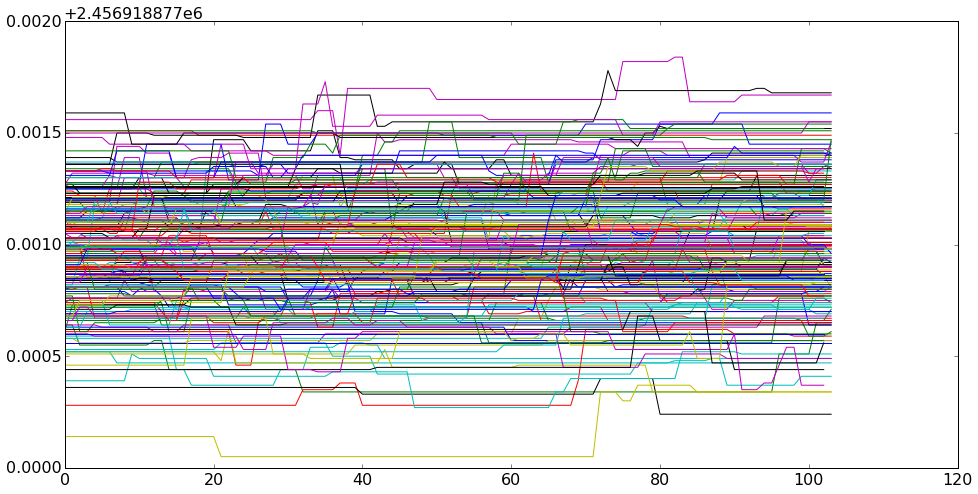

In [111]:
fig, ax = plt.subplots(figsize=(16,8))
n, m = samples.shape
print n, m
for j in [2]:
    [ax.plot(samples[i:,j][::4*m]) for i in range(4*m)]
    plt.show()

## Demo for [WCSAxes](http://nbviewer.ipython.org/github/astrofrog/wcsaxes-examples/blob/master/WCSAxes%20Demo.ipynb)

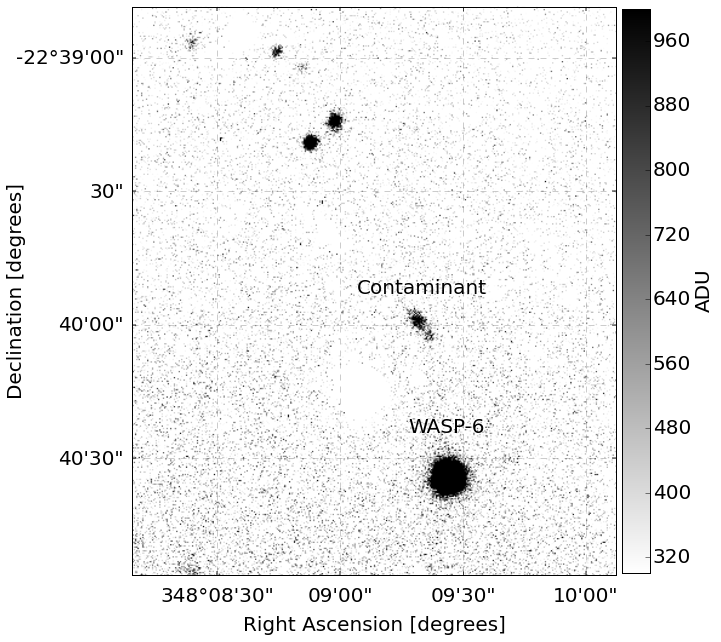

In [80]:
from astropy.wcs import WCS
from astropy.io import fits
from wcsaxes import WCSAxes

matplotlib.rcParams['font.size'] = 20#13
hdu = fits.open('/astro/users/bmmorris/git/research/keck/2014september/analysis/notebooks/nicfpsimgs/sum.fits')[0]

fig = plt.figure(figsize=(10,10))
#fig = plt.figure(figsize=(6,6))
ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=WCS(hdu.header))
fig.add_axes(ax)
#im = ax.imshow(hdu.data, vmin=350, vmax=1000, cmap=plt.cm.binary,
im = ax.imshow(hdu.data, vmin=300, vmax=1000, cmap=plt.cm.binary,
          origin='lower')
ax.coords.grid(color='k', alpha=0.4, linestyle='dashed')
ax.set_xlim([250, 650])
ax.set_ylim([400, 870])

ax.annotate('WASP-6', (510,515), ha='center', va='bottom')
ax.annotate('Contaminant', (490,630), ha='center', va='bottom')

ax.coords[1].set_axislabel('Declination [degrees]', minpad=0)
ax.coords[0].set_axislabel('Right Ascension [degrees]')

#fig.colorbar(cs, ax=ax, shrink=0.9)
matplotlib.rcParams['ytick.major.size'] = 5
cbar = fig.colorbar(im, shrink=0.98, pad=0.01)#, vmin=350, vmax=1000,)
cbar.ax.set_ylabel('ADU')
savecopies(fig, 'galaxy', ['.png'])
plt.show()

## Expected LD:

In [145]:
#http://phoenix.astro.physik.uni-goettingen.de/?page_id=73

prof = pyfits.open('LDfiles/lte05400-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits')
profiles = prof[0].data.T
mu = prof['MU'].data

reflambda = prof[0].header['CRVAL1']
Nlambdas = prof[0].header['NAXIS1']
deltalambdas = prof[0].header['CDELT1']

545536
2.5499


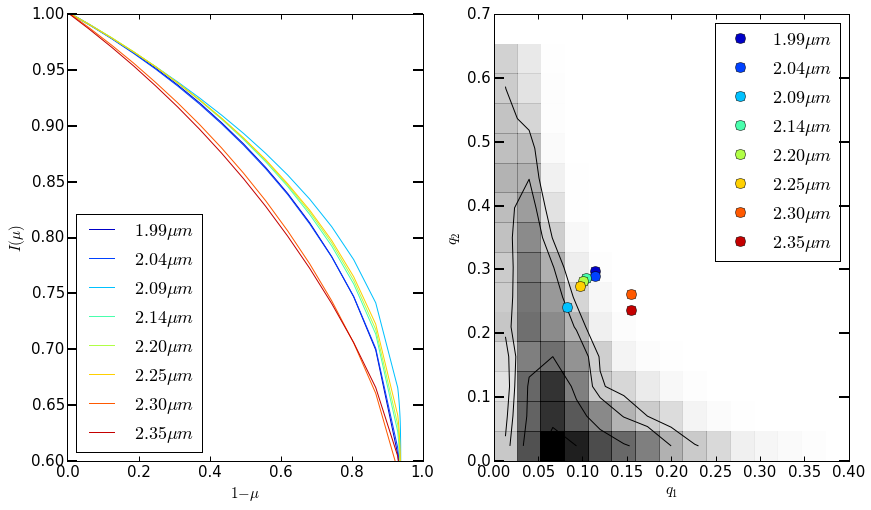

In [146]:
from moar import claretld
lams = np.arange(reflambda, Nlambdas*deltalambdas)*1e-4
#matplotlib.rcParams['font.size']
testwavelengths = wavelengthbincenters.tolist()# + [3.6, 4.5]
cmap = plt.cm.jet

#chains = np.loadtxt('/local/tmp/mosfire/longchains/mosfirespitzer/MpinkSwhite.dat')
#chains = np.loadtxt('/astro/store/scratch/tmp/bmmorris/longchains/mosfirespitzer/MpinkSwhite-parallel.dat')
#allchains = np.vstack([firstchains, chains])
allchains = chains
burnin = int(0.5*allchains.shape[0])
lnp = allchains[burnin:,1]
samples = allchains[burnin:, 2:]
print len(lnp)
print np.max(lams)

fig, ax = plt.subplots(1, 2, figsize=(14, 8))
for i, testlam in enumerate(testwavelengths):
    ind = np.argmin(np.abs(lams - testlam))
    #quad = lambda u, mu: 1 - u[0]*(1 - mu) - u[1]*(1 - mu)**2
    x = 1-mu
    condition = (x < 0.8)
    x = x[condition]
    y = profiles[ind,:][condition]

    bestp = np.polyfit(x, y, 2)
    u1, u2 = -bestp[:2]/bestp[2]
    q1, q2 = claretld.u2q(u1, u2)
    c = cmap((0.5 + i)/len(testwavelengths))
    ax[0].plot(1-mu, profiles[ind,:]/bestp[2], color=c,
            label='${0:.2f}\mu m$'.format(testlam))
    ax[1].plot(q1, q2, 'o', color=c, markersize=10,
            label='${0:.2f}\mu m$'.format(testlam))

ax[0].set_xlabel('$1-\mu$')
ax[0].set_ylabel('$I(\mu)$')
ax[0].set_ylim([0.6, 1])
ax[0].legend(loc='lower left')

ax[1].legend(loc='upper right', numpoints=1)
ax[1].set_xlabel('$q_1$')
ax[1].set_ylabel('$q_2$')

fig.savefig('plots/ld.png')
from triangle import hist2d

hist2d(samples[:,4], samples[:,5], ax=ax[1], bins=15,
      plot_datapoints=False, plot_contours=True, 
      extent=[[0, 0.4], [0, 0.7]]) 
savecopies(fig, 'ld')
plt.show()

## Rp/Rs Table

to convert from white noise hyperparameter $\omega$ to rms of the decorrelated light curve $\sigma_w$, 

$$
\begin{eqnarray}
\sigma_w &=& \sqrt{\left(\frac{\partial f}{\partial \omega} \sigma_\omega \right)^2}\\
f &=& (\exp \omega)^{1/2} \\
\frac{\partial f}{\partial \omega} &=& \frac{1}{2} (\exp \omega)^{1/2}
\end{eqnarray}
$$

In [125]:
Ndecimalplaces = '.4f'

def strform(Ndecimalplaces):
    return '${0:'+Ndecimalplaces+'}^{{+{1:'+Ndecimalplaces+'}}}_{{-{2:'+Ndecimalplaces+'}}}$'

with open('plotsforpaper/rprstable.tex','w') as f:
    f.write('Wavelength [$\mu m$] & $R_p/R_s$ & $\ln c_X$ & $\sigma_w$ & $\ln \\alpha$ & $\ell^2$ \\\\ \\hline \\hline \n')
    labelbounds = wavelengthbounds
    slabels = range(Nbins)+[3.6, 4.5]
    for eachbin in range(Nlightcurves):
        rprs = strform('.3f').format(*medplusminus(samples[:,10+eachbin]))
        
        # Convert white noise hyperparameter to common noise factor sigma
        mw = medplusminus(samples[:,38+eachbin])
        w = strform('.2f').format(*mw)
        convertow = lambda w: np.sqrt(np.exp(w))
        sigma_w = convertow(mw[0])
        sigma_w_upper = np.sqrt( (0.5*convertow(mw[0]+mw[1])*mw[1])**2 )
        sigma_w_lower = np.sqrt( (0.5*convertow(mw[0]-mw[2])*mw[2])**2 )
        sigma = strform('.4f').format(sigma_w, sigma_w_upper, sigma_w_lower)
        

        if eachbin < Nbins:
            lams = "${0:.3f}-{1:.3f}$".format(*labelbounds[eachbin])
            cx = strform('.2f').format(*medplusminus(samples[:,30+eachbin]))
            # Report the red noise amplitude
            ln_alpha = strform('.1f').format(*medplusminus(samples[:,-2*Nbins+eachbin]))
            ell = strform('.2f').format(*medplusminus(samples[:,-1*Nbins+eachbin]))
        else: 
            lams = "${0:.1f}$".format(slabels[eachbin])
            cx = '--'
            ln_alpha = '--'
            ell = '--'
        f.write(' & '.join([lams, rprs, cx, sigma, ln_alpha, ell]) + '\\\\ \n')
    f.write('\\hline')
f = open('plotsforpaper/rprstable.tex','r').read()
with open('/astro/users/bmmorris/Dropbox/sharelatex/MOSFIRE_WASP-6b/tables/rprstable.tex','w') as dbcopy:
    dbcopy.write(f)

In [124]:
%%bash
more plotsforpaper/rprstable.tex

::::::::::::::
plotsforpaper/rprstable.tex
::::::::::::::
Wavelength [$\mu m$] & $R_p/R_s$ & $\ln c_X$ & $\sigma_w$ & $\ln \alpha$ & \ell^2 \\ \hline \hline 
$1.962-2.014$ & $0.130^{+0.004}_{-0.004}$ & $5.54^{+0.82}_{-0.41}$ & $0.0040^{+0.0002}_{-0.0002}$ & $-11.3^{+1.7}_{-1.7}$ & $0.31^{+0.06}_{-0.07}$\\ 
$2.014-2.066$ & $0.130^{+0.002}_{-0.003}$ & $3.99^{+0.07}_{-0.08}$ & $0.0038^{+0.0002}_{-0.0002}$ & $-13.6^{+1.5}_{-1.0}$ & $0.05^{+0.04}_{-0.03}$\\ 
$2.066-2.118$ & $0.133^{+0.005}_{-0.004}$ & $5.10^{+0.35}_{-0.25}$ & $0.0032^{+0.0002}_{-0.0002}$ & $-12.7^{+1.4}_{-1.4}$ & $0.23^{+0.07}_{-0.06}$\\ 
$2.118-2.170$ & $0.133^{+0.002}_{-0.002}$ & $5.48^{+0.31}_{-0.28}$ & $0.0030^{+0.0002}_{-0.0002}$ & $-13.9^{+1.2}_{-0.8}$ & $0.08^{+0.05}_{-0.05}$\\ 
$2.170-2.222$ & $0.144^{+0.003}_{-0.004}$ & $4.93^{+0.24}_{-0.23}$ & $0.0030^{+0.0002}_{-0.0002}$ & $-11.9^{+1.8}_{-1.4}$ & $0.29^{+0.07}_{-0.06}$\\ 
$2.222-2.274$ & $0.140^{+0.004}_{-0.003}$ & $6.11^{+0.86}_{-0.65}$ & $0.0035^{+0.0002}_{-0.0